In [1]:
! rm -rf data_prep.pyc

In [2]:
import data_prep
mnist=data_prep.mnist_data_prep()
cifar=data_prep.cifar_prep()
letters=data_prep.letters_prep()

Using TensorFlow backend.


In [3]:
import numpy as np
import cPickle
import csv
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import scipy
import multiprocessing
from multiprocessing import pool,Pool
from functools import partial

Set the GPU to Use

In [4]:
GPU_NO="0"
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = GPU_NO
#session = tf.Session(config=config)
set_session(tf.Session(config=config))

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation,Flatten,Input,Conv2D,MaxPooling2D,Dropout,BatchNormalization,Activation
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint,LearningRateScheduler
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras import backend as K

In [6]:
def concatenate_training_data(obj,y,cross_entropy_probs,ring_loss=False):
    """
    Parameters:
        obj: is an object from a class in file data_prep.py
        y: are the images from the class that needs to be trained as negatives example cifar.images or letters.images
        cross_entropy_probs: Multiplier to the categorical labels
        ring_loss: Boolean value returns Y_pred_flags (Default:False)
    Returns:
        X_train_data: Numpy array containing training samples
        Y_train_data: Numpy array containing Label values
        sample_weights: 1D Numpy array containing weight of each sample
        Y_train_flags: Returned only when ring_loss=True. Numpy array containing flags indicating the sample is a known versus known unknown
    """
    X_train_data=np.concatenate((obj.X_train,y))
    Y_train_data=np.concatenate((obj.Y_train,np.ones((y.shape[0],10))*cross_entropy_probs))
    class_no=np.argmax(obj.Y_train,axis=1)
    sample_weights_knowns=np.zeros_like(class_no).astype(np.float32)
    for cls in range(obj.Y_train.shape[1]):
        sample_weights_knowns[class_no==cls]=100./len(class_no[class_no==cls])
    sample_weights=np.concatenate([sample_weights_knowns,np.ones((y.shape[0]))*(100./y.shape[0])])
    if ring_loss:
        Y_train_flags=np.zeros((X_train_data.shape[0],2))
        Y_train_flags[:obj.X_train.shape[0],0]=1
        Y_train_flags[obj.X_train.shape[0]:,1]=1
        return X_train_data,Y_train_data,sample_weights,Y_train_flags
    else:
        return X_train_data,Y_train_data,sample_weights

In [7]:
def LeNet_plus_plus(perform_L2_norm=False,activation_type='softmax',ring_approach=False):
    
    mnist_image = Input(shape=(28, 28, 1), dtype='float32', name='mnist_image')

    # 28 X 28 --> 14 X 14
    conv1_1 = Conv2D(32, (5,5), strides=1, padding="same",name='conv1_1')(mnist_image)
    conv1_2 = Conv2D(32, (5,5), strides=1, padding="same",name='conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    pool1 = MaxPooling2D(pool_size=(2,2), strides=2,name='pool1')(conv1_2)
    # 14 X 14 --> 7 X 7
    conv2_1 = Conv2D(64, (5,5), strides=1, padding="same", name='conv2_1')(pool1)
    conv2_2 = Conv2D(64, (5,5), strides=1, padding="same", name='conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    pool2 = MaxPooling2D(pool_size=(2,2), strides=2, name='pool2')(conv2_2)
    # 7 X 7 --> 3 X 3
    conv3_1 = Conv2D(128, (5,5), strides=1, padding="same",name='conv3_1')(pool2)
    conv3_2 = Conv2D(128, (5,5), strides=1, padding="same",name='conv3_2')(conv3_1)
    conv3_2 = BatchNormalization()(conv3_2)
    pool3 = MaxPooling2D(pool_size=(2,2), strides=2, name='pool3')(conv3_2)
    flatten=Flatten(name='flatten')(pool3)
    fc = Dense(2,name='fc')(flatten)

    if perform_L2_norm:
        alpha_multipliers = Input((1,), dtype='float32', name='alphas')
        act = Activation(lambda x: alpha_multipliers*(K.l2_normalize(x,axis=1)),name='act')(fc)
        pred = Dense(10, activation=activation_type,name='pred')(act)
        model = Model(inputs=[mnist_image,alpha_multipliers], outputs=[pred])
    elif ring_approach:
        knownUnknownsFlag = Input((1,), dtype='float32', name='knownUnknownsFlag')
        pred = Dense(10, activation=activation_type,name='pred')(fc)
        model = Model(inputs=[mnist_image,unknownsMaximumMag,knownsMinimumMag], outputs=[pred,fc])
        #model = Model(inputs=[mnist_image,unknownsMaximumMag,knownsMinimumMag,knownUnknownsFlag], outputs=[pred,fc])
    else:
        pred = Dense(10, activation=activation_type,name='pred')(fc)
        model = Model(inputs=[mnist_image], outputs=[pred])
    return model

In [8]:
def extract_features(model,data):
    layer_name = ['fc','pred']
#    intermediate_layer_model = Model(inputs=model.input,
#                                 outputs=model.get_layer(layer_name).output)
    intermediate_layer_model = Model(inputs=model.input,
                                 outputs=[model.get_layer(layer_name[0]).output,model.get_layer(layer_name[1]).output])
    print model.input_shape,len(model.input_shape)
    if len(model.input_shape)==4:
        intermediate_output = intermediate_layer_model.predict([data])
    elif len(model.input_shape)==3:
        intermediate_output = intermediate_layer_model.predict([data,np.ones(data.shape[0]),np.ones(data.shape[0])])        
    else:
        intermediate_output = intermediate_layer_model.predict([data,np.ones(data.shape[0])])
    return intermediate_output

In [9]:
def plotter_2D(pos_values,l,neg_values=None):
    plt.scatter(pos_values[:,0], pos_values[:,1], c=data_prep.colors[l.astype(np.int)],edgecolors='none',s=0.5)
    if neg_values is not None:
        plt.scatter(neg_values[:,0], neg_values[:,1],c='k',edgecolors='none',s=15,marker="*")
    plt.axis([np.min(pos_values[:,0]), np.max(pos_values[:,0]),np.min(pos_values[:,1]), np.max(pos_values[:,1])])
    plt.show()
    
    if neg_values is not None:
        pos_mag=np.sqrt(np.sum(np.square(pos_values),axis=1))
        neg_mag=np.sqrt(np.sum(np.square(neg_values),axis=1))
        pos_hist=np.histogram(pos_mag, bins=1000)#'auto')
        neg_hist=np.histogram(neg_mag, bins=1000)#'auto')
        plt.plot(pos_hist[1][1:],pos_hist[0].astype(np.float16)/max(pos_hist[0]),label='Knowns',color='g')
        plt.plot(neg_hist[1][1:],neg_hist[0].astype(np.float16)/max(neg_hist[0]),color='r',label='Unknowns')
        plt.legend()
        plt.title("Histogram")
        plt.show()

In [10]:
def ring_loss(y_true,y_pred):
    pred=K.sqrt(K.sum(K.square(y_pred),axis=1))
    error=K.mean(K.square(
        # Loss for Knowns having magnitude greater than knownsMinimumMag
        y_true[:,0]*(K.maximum(knownsMinimumMag-pred,0.))
        # Add two losses
        +
        # Loss for unKnowns having magnitude greater than unknownsMaximumMag
        y_true[:,1]*(K.maximum(pred-unknownsMaximumMag,0.))
    ))
    return error

In [11]:
unknownsMaximumMag = Input((1,), dtype='float32', name='unknownsMaximumMag')
knownsMinimumMag = Input((1,), dtype='float32', name='knownsMinimumMag')
knownsMinimumMag_ = np.ones((1))*500
unknownsMaximumMag_ = np.ones((1))*10

In [12]:
Ring_Loss_Lenet_pp=LeNet_plus_plus(ring_approach=True)
Ring_Loss_Lenet_pp.load_weights('ring_loss_weights')

In [13]:
mnist_intermediate_output=extract_features(Ring_Loss_Lenet_pp,mnist.X_test)
letters_intermediate_output=extract_features(Ring_Loss_Lenet_pp,letters.X_test)
cifar_intermediate_output=extract_features(Ring_Loss_Lenet_pp,cifar.images)

[(None, 28, 28, 1), (None, 1), (None, 1)] 3
[(None, 28, 28, 1), (None, 1), (None, 1)] 3
[(None, 28, 28, 1), (None, 1), (None, 1)] 3


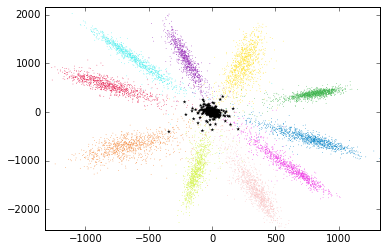

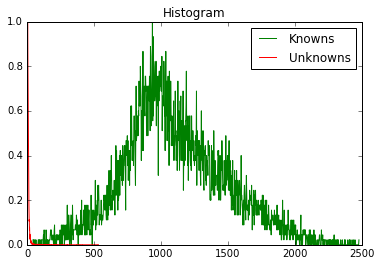

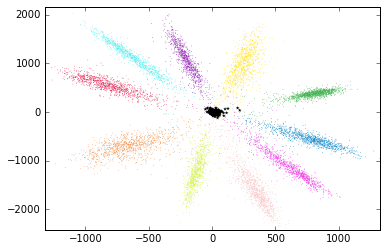

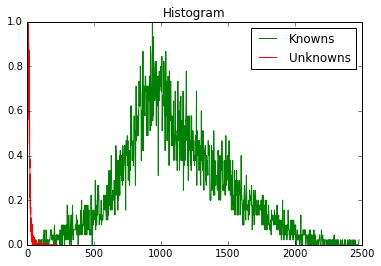

In [14]:
plotter_2D(mnist_intermediate_output[0],mnist.labels_test,letters_intermediate_output[0])
plotter_2D(mnist_intermediate_output[0],mnist.labels_test,cifar_intermediate_output[0])

In [15]:
def write_to_file(gt_y,pred_y,file_name,data_x=None):
    # 'GALLERY_SUBJECT_ID','GALLERY_TEMPLATE_ID','PROBE_SUBJECT_ID','PROBE_TEMPLATE_ID','SIMILARITY_SCORE'
    # 'PRED_SUBJECT_ID','PRED_TEMPLATE_ID','GT_SUBJECT_ID','GT_TEMPLATE_ID','SIMILARITY_SCORE'
    if pred_y.shape[1]==11:
        pred_y=pred_y[:,:-1]
    similarity_score=pred_y.flatten('F')
    pred=np.repeat(np.arange(10),pred_y.shape[0])
    print pred.shape
    ind_gt=np.tile(np.arange(gt_y.shape[0]),10)
    gt_y=np.tile(gt_y,10)
    if data_x is not None:
        similarity_score=similarity_score*np.tile(np.sqrt(np.sum(np.square(data_x),axis=1)),10)
    print pred.shape,gt_y.shape,similarity_score.shape
    x=np.stack((pred,pred,gt_y,ind_gt,similarity_score),axis=1)
    np.savetxt(file_name, x, delimiter=' ',fmt=['%d','%d','%d','%d','%f'])

In [25]:
write_to_file(np.concatenate((np.argmax(mnist.Y_test,axis=1),np.ones((letters_intermediate_output[1].shape[0]))*10)),
              np.concatenate((mnist_intermediate_output[1],letters_intermediate_output[1])),
              'ring_mnist_letter.txt',data_x=np.concatenate((mnist_intermediate_output[0],letters_intermediate_output[0])))
write_to_file(np.concatenate((np.argmax(mnist.Y_test,axis=1),np.ones((cifar_intermediate_output[1].shape[0]))*10)),
              np.concatenate((mnist_intermediate_output[1],cifar_intermediate_output[1])),
              'ring_mnist_cifar.txt',data_x=np.concatenate((mnist_intermediate_output[0],cifar_intermediate_output[0])))

(308000,)
(308000,) (308000,) (308000,)
(200000,)
(200000,) (200000,) (200000,)


In [18]:
write_to_file(np.argmax(mnist.Y_test,axis=1),mnist_intermediate_output[1],'ring_mnist_file.txt',data_x=mnist_intermediate_output[0])
write_to_file(np.ones((letters_intermediate_output[1].shape[0]))*10,letters_intermediate_output[1],'ring_letters_file.txt',data_x=letters_intermediate_output[0])
write_to_file(np.ones((cifar_intermediate_output[1].shape[0]))*10,cifar_intermediate_output[1],'ring_cifar_file.txt',data_x=cifar_intermediate_output[0])

(100000,)
(100000,) (100000,) (100000,)
(208000,)
(208000,) (208000,) (208000,)
(100000,)
(100000,) (100000,) (100000,)


In [26]:
mnist_with_bg=keras.models.load_model('mnist_with_bg')

In [27]:
mnist_intermediate_output=extract_features(mnist_with_bg,mnist.X_test)
letters_intermediate_output=extract_features(mnist_with_bg,letters.X_test)
cifar_intermediate_output=extract_features(mnist_with_bg,cifar.images)

(None, 28, 28, 1) 4
(None, 28, 28, 1) 4
(None, 28, 28, 1) 4


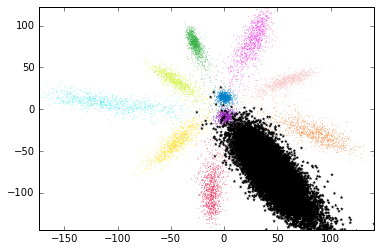

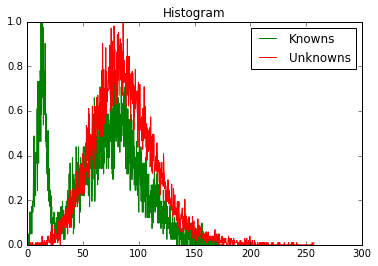

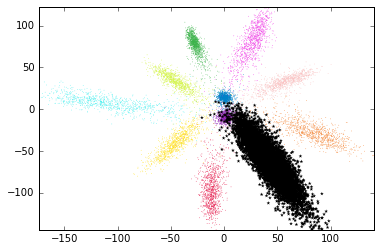

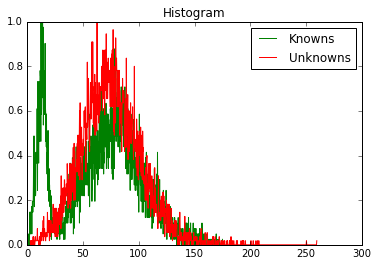

In [28]:
plotter_2D(mnist_intermediate_output[0],mnist.labels_test,letters_intermediate_output[0])
plotter_2D(mnist_intermediate_output[0],mnist.labels_test,cifar_intermediate_output[0])

In [29]:
write_to_file(np.concatenate((np.argmax(mnist.Y_test,axis=1),np.ones((letters_intermediate_output[1].shape[0]))*10)),
              np.concatenate((mnist_intermediate_output[1],letters_intermediate_output[1])),
              'bg_mnist_letter.txt',data_x=np.concatenate((mnist_intermediate_output[0],letters_intermediate_output[0])))
write_to_file(np.concatenate((np.argmax(mnist.Y_test,axis=1),np.ones((cifar_intermediate_output[1].shape[0]))*10)),
              np.concatenate((mnist_intermediate_output[1],cifar_intermediate_output[1])),
              'bg_mnist_cifar.txt',data_x=np.concatenate((mnist_intermediate_output[0],cifar_intermediate_output[0])))

(308000,)
(308000,) (308000,) (308000,)
(200000,)
(200000,) (200000,) (200000,)


In [33]:
res=mnist_with_bg.evaluate(x=[mnist.X_test], y=[np.concatenate((mnist.Y_test,np.zeros((mnist.Y_test.shape[0],1))),axis=1)])
print mnist_with_bg.metrics_names
print res
res=mnist_with_bg.evaluate(x=[mnist.X_train], y=[mnist.Y_train])
print "train",res

10000/10000 [==============================] - 2s 166us/step
['loss', 'acc']
[0.18372516026324884, 0.97140000000000004]


ValueError: Error when checking target: expected pred to have shape (11,) but got array with shape (10,)

In [21]:
write_to_file(np.argmax(mnist.Y_test,axis=1),mnist_intermediate_output[1],'bg_mnist_file.txt')
write_to_file(np.ones((letters_intermediate_output[1].shape[0]))*10,letters_intermediate_output[1],'bg_letters_file.txt')
write_to_file(np.ones((cifar_intermediate_output[1].shape[0]))*10,cifar_intermediate_output[1],'bg_cifar_file.txt')

(100000,)
(100000,) (100000,) (100000,)
(208000,)
(208000,) (208000,) (208000,)
(100000,)
(100000,) (100000,) (100000,)


### Raw MNIST trained with LETTERS Samples as negatives (CrossEntropy Label for negatives = 0.1)

In [11]:
X_train,Y_train,sample_weights=concatenate_training_data(mnist,letters.X_train,100.)
negative_training_lenet_pp=LeNet_plus_plus()
adam = Adam(lr=0.1)
negative_training_lenet_pp.compile(optimizer=adam,loss={'pred': 'categorical_crossentropy'},metrics=['accuracy'])
info=negative_training_lenet_pp.fit(x=[X_train],y=[Y_train], batch_size=64, epochs=3,verbose=1,sample_weight=sample_weights)

Epoch 1/3
147840/147840 [==============================] - 116s 785us/step - loss: 1.6218 - acc: 0.1063
Epoch 2/3
147840/147840 [==============================] - 43s 289us/step - loss: 1.5730 - acc: 0.1972
Epoch 3/3
147840/147840 [==============================] - 43s 289us/step - loss: 5.3671 - acc: 0.0982


In [12]:
info=negative_training_lenet_pp.fit(x=[X_train],y=[Y_train], batch_size=64, epochs=3,verbose=1,sample_weight=sample_weights)

Epoch 1/3
147840/147840 [==============================] - 42s 285us/step - loss: 9.9103 - acc: 0.0324
Epoch 2/3
147840/147840 [==============================] - 42s 285us/step - loss: 9.9103 - acc: 0.0324
Epoch 3/3
147840/147840 [==============================] - 42s 287us/step - loss: 9.9103 - acc: 0.0324


In [13]:
def find_hard_negatives(model,X,Y):
    losses=[]
    for i in range(X.shape[0]):
        #info = model.evaluate(x=[X[i][np.newaxis,...]],y=[Y[i][np.newaxis,...]],verbose=0)
        #losses.append((info[0],i))
        info = model.evaluate(x=[X[i][np.newaxis,...],np.ones((1)),np.ones((1))],y=[Y[i][np.newaxis,...],np.ones((1,2))],verbose=0)
        losses.append((info[2],i))
    losses.sort()
    loss,hard_negatives=zip(*losses)
    hard_negatives=np.array(hard_negatives)
    return hard_negatives

In [24]:
adam = Adam(lr=0.001)
negative_training_lenet_pp.compile(optimizer=adam,loss={'pred': 'categorical_crossentropy'},metrics=['accuracy'])
info=negative_training_lenet_pp.fit(x=[np.concatenate([mnist.X_train,X_train[hard_negatives[-10000:]]])],y=[np.concatenate([mnist.Y_train,Y_train[hard_negatives[-10000:]]])], batch_size=64, epochs=3,verbose=1)

Epoch 1/3
58000/58000 [==============================] - 18s 306us/step - loss: 0.4565 - acc: 0.8284
Epoch 2/3
58000/58000 [==============================] - 17s 287us/step - loss: 0.4453 - acc: 0.8307
Epoch 3/3
58000/58000 [==============================] - 17s 288us/step - loss: 0.4365 - acc: 0.8340


In [15]:
res=negative_training_lenet_pp.evaluate(x=[mnist.X_test], y=[mnist.Y_test])
print negative_training_lenet_pp.metrics_names
print res
res=negative_training_lenet_pp.evaluate(x=[mnist.X_train], y=[mnist.Y_train])
print "train",res

10000/10000 [==============================] - 2s 158us/step
['loss', 'acc']
[2.0800399318695066, 0.25969999999999999]
48000/48000 [==============================] - 7s 146us/step
train [2.0849372591972353, 0.26204166666666667]


(None, 28, 28, 1) 4
(None, 28, 28, 1) 4


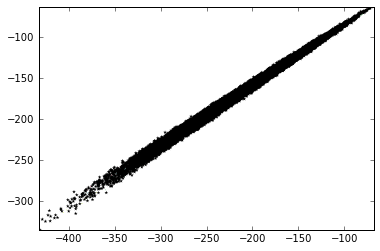

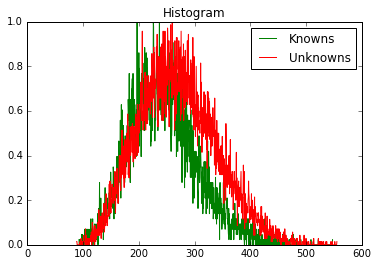

In [14]:
mnist_intermediate_output=extract_features(negative_training_lenet_pp,mnist.X_test)
letters_intermediate_output=extract_features(negative_training_lenet_pp,letters.X_test)
plotter_2D(mnist_intermediate_output,mnist.labels_test,letters_intermediate_output)

(None, 28, 28, 1) 4
(None, 28, 28, 1) 4


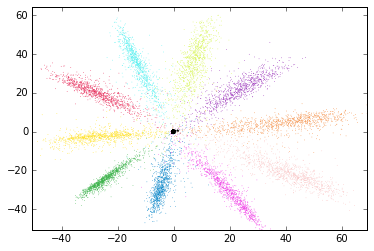

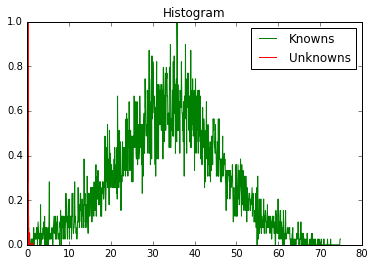

In [18]:
mnist_intermediate_output=extract_features(negative_training_lenet_pp,mnist.X_test)
cifar_intermediate_output=extract_features(negative_training_lenet_pp,cifar.images)
plotter_2D(mnist_intermediate_output,mnist.labels_test,cifar_intermediate_output)

### Training with Ring Loss

In [11]:
def ring_loss(y_true,y_pred):
    pred=K.sqrt(K.sum(K.square(y_pred),axis=1))
    error=K.mean(K.square(
        # Loss for Knowns having magnitude greater than knownsMinimumMag
        y_true[:,0]*(K.maximum(knownsMinimumMag-pred,0.))
        # Add two losses
        +
        # Loss for unKnowns having magnitude greater than unknownsMaximumMag
        y_true[:,1]*(K.maximum(pred-unknownsMaximumMag,0.))
    ))
    return error

In [12]:
X_train,Y_train,sample_weights,Y_pred_with_flags=concatenate_training_data(mnist,letters.X_train,0.1,ring_loss=True)

In [13]:
unknownsMaximumMag = Input((1,), dtype='float32', name='unknownsMaximumMag')
knownsMinimumMag = Input((1,), dtype='float32', name='knownsMinimumMag')
knownsMinimumMag_ = np.ones((X_train.shape[0]))*500
unknownsMaximumMag_ = np.ones((X_train.shape[0]))*10

In [14]:
Ring_Loss_Lenet_pp=LeNet_plus_plus(ring_approach=True)

In [15]:
adam = Adam(lr=0.01)
Ring_Loss_Lenet_pp.compile(optimizer=adam,loss={'pred': 'categorical_crossentropy','fc':ring_loss},loss_weights={'pred': 1., 'fc': 0.},metrics=['accuracy'])
info=Ring_Loss_Lenet_pp.fit(x=[X_train,unknownsMaximumMag_,knownsMinimumMag_],y=[Y_train,Y_pred_with_flags], batch_size=128, epochs=5,verbose=1,sample_weight=[sample_weights,sample_weights])

Epoch 1/5
147840/147840 [==============================] - 173s 1ms/step - loss: 0.0083 - pred_loss: 0.0083 - fc_loss: 575.9713 - pred_acc: 0.2980 - fc_acc: 0.5314
Epoch 2/5
147840/147840 [==============================] - 33s 225us/step - loss: 0.0046 - pred_loss: 0.0046 - fc_loss: 552.9690 - pred_acc: 0.3232 - fc_acc: 0.4688
Epoch 3/5
147840/147840 [==============================] - 34s 228us/step - loss: 0.0040 - pred_loss: 0.0040 - fc_loss: 543.2078 - pred_acc: 0.3246 - fc_acc: 0.4410
Epoch 4/5
147840/147840 [==============================] - 34s 230us/step - loss: 0.0037 - pred_loss: 0.0037 - fc_loss: 536.2671 - pred_acc: 0.3270 - fc_acc: 0.4582
Epoch 5/5
147840/147840 [==============================] - 34s 229us/step - loss: 0.0034 - pred_loss: 0.0034 - fc_loss: 532.3220 - pred_acc: 0.3277 - fc_acc: 0.4547


In [ ]:
adam = Adam(lr=0.001)
Ring_Loss_Lenet_pp.compile(optimizer=adam,loss={'pred': 'categorical_crossentropy','fc':ring_loss},loss_weights={'pred': 1., 'fc': 0.0001},metrics=['accuracy'])
info=Ring_Loss_Lenet_pp.fit(x=[X_train,unknownsMaximumMag_,knownsMinimumMag_],y=[Y_train,Y_pred_with_flags], batch_size=256, epochs=60,verbose=1,sample_weight=[sample_weights*3,sample_weights])

Epoch 1/60
147840/147840 [==============================] - 26s 175us/step - loss: 0.0502 - pred_loss: 0.0112 - fc_loss: 389.1302 - pred_acc: 0.3362 - fc_acc: 0.4563
Epoch 2/60
147840/147840 [==============================] - 26s 178us/step - loss: 0.0335 - pred_loss: 0.0142 - fc_loss: 192.8192 - pred_acc: 0.3417 - fc_acc: 0.4663
Epoch 3/60
147840/147840 [==============================] - 26s 175us/step - loss: 0.0246 - pred_loss: 0.0138 - fc_loss: 107.6606 - pred_acc: 0.3452 - fc_acc: 0.4637
Epoch 4/60
147840/147840 [==============================] - 26s 174us/step - loss: 0.0198 - pred_loss: 0.0126 - fc_loss: 71.3995 - pred_acc: 0.3502 - fc_acc: 0.4584
Epoch 5/60
147840/147840 [==============================] - 26s 178us/step - loss: 0.0168 - pred_loss: 0.0114 - fc_loss: 54.0608 - pred_acc: 0.3558 - fc_acc: 0.4543
Epoch 6/60
147840/147840 [==============================] - 26s 174us/step - loss: 0.0148 - pred_loss: 0.0104 - fc_loss: 43.9734 - pred_acc: 0.3563 - fc_acc: 0.4501
Epoch 7

In [34]:
Ring_Loss_Lenet_pp.save('ring_loss_new')

In [43]:
model_json = Ring_Loss_Lenet_pp.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
json_file.close()

In [42]:
Ring_Loss_Lenet_pp.save_weights('ring_loss_weights')

In [37]:
info=Ring_Loss_Lenet_pp.fit(x=[X_train,unknownsMaximumMag_,knownsMinimumMag_],y=[Y_train,Y_pred_with_flags], batch_size=256, epochs=1,verbose=1,sample_weight=[sample_weights*2,sample_weights])

Epoch 1/1
147840/147840 [==============================] - 26s 176us/step - loss: 0.0034 - pred_loss: 0.0034 - fc_loss: 0.3246 - pred_acc: 0.3947 - fc_acc: 0.4821


In [32]:
res=Ring_Loss_Lenet_pp.evaluate(x=[mnist.X_test,np.ones((mnist.X_test.shape[0],1)),np.ones((mnist.X_test.shape[0],1))], y=[mnist.Y_test,np.ones((mnist.Y_test.shape[0],2))])
print Ring_Loss_Lenet_pp.metrics_names
print res
res=Ring_Loss_Lenet_pp.evaluate(x=[mnist.X_train,np.ones((mnist.X_train.shape[0],1)),np.ones((mnist.X_train.shape[0],1))], y=[mnist.Y_train,np.ones((mnist.Y_train.shape[0],2))])
print "train",res

10000/10000 [==============================] - 2s 208us/step
['loss', 'pred_loss', 'fc_loss', 'pred_acc', 'fc_acc']
[134.97397536621094, 0.14114614763862918, 1348328.3258, 0.9719, 0.573]
48000/48000 [==============================] - 10s 211us/step
train [134.57532280985515, 0.01192406366202825, 1345634.0227916667, 0.9994166666666666, 0.5731458333333334]


In [16]:
adam = Adam(lr=0.01)
Ring_Loss_Lenet_pp.compile(optimizer=adam,loss={'pred': 'categorical_crossentropy','fc':ring_loss},loss_weights={'pred': 1., 'fc': 0.},metrics=['accuracy'])
info=Ring_Loss_Lenet_pp.fit(x=[X_train,unknownsMaximumMag_,knownsMinimumMag_],y=[Y_train,Y_pred_with_flags], batch_size=64, epochs=3,verbose=1,sample_weight=[sample_weights,sample_weights])

Epoch 1/3
147840/147840 [==============================] - 189s 1ms/step - loss: 0.0069 - pred_loss: 0.0069 - fc_loss: 574.2954 - pred_acc: 0.3019 - fc_acc: 0.4687
Epoch 2/3
147840/147840 [==============================] - 50s 339us/step - loss: 0.0045 - pred_loss: 0.0045 - fc_loss: 557.9371 - pred_acc: 0.3105 - fc_acc: 0.4336
Epoch 3/3
147840/147840 [==============================] - 50s 342us/step - loss: 0.0040 - pred_loss: 0.0040 - fc_loss: 555.5688 - pred_acc: 0.3140 - fc_acc: 0.4151


In [19]:
Ring_Loss_Lenet_pp.compile(optimizer=adam,loss={'pred': 'categorical_crossentropy','fc':ring_loss},loss_weights={'pred': 1., 'fc': 0.00001},metrics=['accuracy'])
info=Ring_Loss_Lenet_pp.fit(x=[X_train,unknownsMaximumMag_,knownsMinimumMag_],y=[Y_train,Y_pred_with_flags], batch_size=64, epochs=5,verbose=1,sample_weight=[sample_weights*1,sample_weights])

Epoch 1/5
147840/147840 [==============================] - 51s 347us/step - loss: 0.0070 - pred_loss: 0.0050 - fc_loss: 191.8869 - pred_acc: 0.3154 - fc_acc: 0.4056
Epoch 2/5
147840/147840 [==============================] - 51s 345us/step - loss: 0.0050 - pred_loss: 0.0037 - fc_loss: 123.1069 - pred_acc: 0.3320 - fc_acc: 0.3930
Epoch 3/5
147840/147840 [==============================] - 51s 346us/step - loss: 0.0047 - pred_loss: 0.0037 - fc_loss: 97.8850 - pred_acc: 0.3413 - fc_acc: 0.4622
Epoch 4/5
147840/147840 [==============================] - 51s 345us/step - loss: 0.0045 - pred_loss: 0.0037 - fc_loss: 85.9572 - pred_acc: 0.3484 - fc_acc: 0.4906
Epoch 5/5
147840/147840 [==============================] - 51s 346us/step - loss: 0.0042 - pred_loss: 0.0035 - fc_loss: 70.2043 - pred_acc: 0.3432 - fc_acc: 0.4945


In [20]:
Ring_Loss_Lenet_pp.compile(optimizer=adam,loss={'pred': 'categorical_crossentropy','fc':ring_loss},loss_weights={'pred': 1., 'fc': 0.0001},metrics=['accuracy'])
info=Ring_Loss_Lenet_pp.fit(x=[X_train,unknownsMaximumMag_,knownsMinimumMag_],y=[Y_train,Y_pred_with_flags], batch_size=64, epochs=5,verbose=1,sample_weight=[sample_weights*5,sample_weights])

Epoch 1/5
147840/147840 [==============================] - 52s 353us/step - loss: 0.0349 - pred_loss: 0.0262 - fc_loss: 86.3867 - pred_acc: 0.3364 - fc_acc: 0.5077
Epoch 2/5
147840/147840 [==============================] - 51s 347us/step - loss: 0.0262 - pred_loss: 0.0216 - fc_loss: 46.4238 - pred_acc: 0.3539 - fc_acc: 0.5151
Epoch 3/5
147840/147840 [==============================] - 51s 347us/step - loss: 0.0221 - pred_loss: 0.0180 - fc_loss: 41.0832 - pred_acc: 0.3562 - fc_acc: 0.5123
Epoch 4/5
147840/147840 [==============================] - 51s 346us/step - loss: 0.0265 - pred_loss: 0.0223 - fc_loss: 41.8914 - pred_acc: 0.3535 - fc_acc: 0.5154
Epoch 5/5
147840/147840 [==============================] - 51s 347us/step - loss: 0.0213 - pred_loss: 0.0175 - fc_loss: 38.4490 - pred_acc: 0.3614 - fc_acc: 0.5164


In [ ]:
Ring_Loss_Lenet_pp.compile(optimizer=adam,loss={'pred': 'categorical_crossentropy','fc':ring_loss},loss_weights={'pred': 1., 'fc': 0.0001},metrics=['accuracy'])
info=Ring_Loss_Lenet_pp.fit(x=[X_train,unknownsMaximumMag_,knownsMinimumMag_],y=[Y_train,Y_pred_with_flags], batch_size=64, epochs=25,verbose=1,sample_weight=[sample_weights*5,sample_weights])

Epoch 1/25
147840/147840 [==============================] - 52s 354us/step - loss: 0.0936 - pred_loss: 0.0904 - fc_loss: 32.6573 - pred_acc: 0.3433 - fc_acc: 0.4693
Epoch 2/25
147840/147840 [==============================] - 51s 345us/step - loss: 0.0703 - pred_loss: 0.0679 - fc_loss: 23.5403 - pred_acc: 0.3575 - fc_acc: 0.4691
Epoch 3/25
147840/147840 [==============================] - 51s 347us/step - loss: 0.0708 - pred_loss: 0.0684 - fc_loss: 23.8041 - pred_acc: 0.3583 - fc_acc: 0.4749
Epoch 4/25
147840/147840 [==============================] - 51s 348us/step - loss: 0.0699 - pred_loss: 0.0677 - fc_loss: 21.9743 - pred_acc: 0.3573 - fc_acc: 0.4661
Epoch 5/25
147840/147840 [==============================] - 51s 348us/step - loss: 0.0698 - pred_loss: 0.0674 - fc_loss: 24.0290 - pred_acc: 0.3492 - fc_acc: 0.4621
Epoch 6/25
147840/147840 [==============================] - 51s 347us/step - loss: 0.0328 - pred_loss: 0.0300 - fc_loss: 27.1769 - pred_acc: 0.3681 - fc_acc: 0.4856
Epoch 7/25

In [33]:
#adam = Adam(lr=0.01)
Ring_Loss_Lenet_pp.compile(optimizer=adam,loss={'pred': 'categorical_crossentropy','fc':ring_loss},loss_weights={'pred': 1., 'fc': 0.001},metrics=['accuracy'])
info=Ring_Loss_Lenet_pp.fit(x=[X_train,unknownsMaximumMag_,knownsMinimumMag_],y=[Y_train,Y_pred_with_flags], batch_size=64, epochs=5,verbose=1,sample_weight=[sample_weights*10,sample_weights])

Epoch 1/5
147840/147840 [==============================] - 53s 359us/step - loss: 0.3214 - pred_loss: 0.2984 - fc_loss: 23.0482 - pred_acc: 0.3307 - fc_acc: 0.4360
Epoch 2/5
147840/147840 [==============================] - 52s 349us/step - loss: 0.3281 - pred_loss: 0.3151 - fc_loss: 13.0066 - pred_acc: 0.3251 - fc_acc: 0.4394
Epoch 3/5
147840/147840 [==============================] - 51s 348us/step - loss: 0.2676 - pred_loss: 0.2566 - fc_loss: 11.0691 - pred_acc: 0.3335 - fc_acc: 0.4572
Epoch 4/5
147840/147840 [==============================] - 51s 348us/step - loss: 0.2635 - pred_loss: 0.2542 - fc_loss: 9.3376 - pred_acc: 0.3232 - fc_acc: 0.4691
Epoch 5/5
147840/147840 [==============================] - 51s 348us/step - loss: 0.2639 - pred_loss: 0.2546 - fc_loss: 9.3825 - pred_acc: 0.3318 - fc_acc: 0.4770


In [19]:
info=Ring_Loss_Lenet_pp.fit(x=[X_train,unknownsMaximumMag_,knownsMinimumMag_],y=[Y_train,Y_pred_with_flags], batch_size=64, epochs=15,verbose=1,sample_weight=[sample_weights*3,sample_weights])

Epoch 1/15
147840/147840 [==============================] - 50s 341us/step - loss: 0.0400 - pred_loss: 0.0303 - fc_loss: 9.7007 - pred_acc: 0.3757 - fc_acc: 0.4771
Epoch 2/15
147840/147840 [==============================] - 51s 345us/step - loss: 0.0490 - pred_loss: 0.0408 - fc_loss: 8.2708 - pred_acc: 0.3675 - fc_acc: 0.4802
Epoch 3/15
147840/147840 [==============================] - 51s 345us/step - loss: 0.0653 - pred_loss: 0.0578 - fc_loss: 7.5130 - pred_acc: 0.3493 - fc_acc: 0.4792
Epoch 4/15
147840/147840 [==============================] - 51s 346us/step - loss: 0.0665 - pred_loss: 0.0601 - fc_loss: 6.4161 - pred_acc: 0.3435 - fc_acc: 0.4856
Epoch 5/15
147840/147840 [==============================] - 51s 345us/step - loss: 0.0945 - pred_loss: 0.0892 - fc_loss: 5.2802 - pred_acc: 0.3107 - fc_acc: 0.4897
Epoch 6/15
147840/147840 [==============================] - 51s 344us/step - loss: 0.1211 - pred_loss: 0.1160 - fc_loss: 5.0836 - pred_acc: 0.2695 - fc_acc: 0.4956
Epoch 7/15
14784

In [20]:
hard_negatives=find_hard_negatives(Ring_Loss_Lenet_pp,X_train,Y_train)
print hard_negatives

[135408  94589  93980 ...   1731   6244  29886]


In [22]:
ind=hard_negatives[-10000:]

In [25]:
adam = Adam(lr=0.01)
Ring_Loss_Lenet_pp.compile(optimizer=adam,loss={'pred': 'categorical_crossentropy','fc':ring_loss},loss_weights={'pred': 1., 'fc': 0.001},metrics=['accuracy'])
info=Ring_Loss_Lenet_pp.fit(
    x=[np.concatenate([mnist.X_train,X_train[ind]]),
       np.concatenate([unknownsMaximumMag_[:mnist.X_train.shape[0],...],unknownsMaximumMag_[ind]]),
       np.concatenate([knownsMinimumMag_[:mnist.X_train.shape[0],...],knownsMinimumMag_[ind]])
      ],
    y=[np.concatenate([mnist.Y_train,Y_train[ind]]),
       np.concatenate([Y_pred_with_flags[:mnist.X_train.shape[0],...],Y_pred_with_flags[ind]])
      ], batch_size=64, epochs=15,verbose=1)

Epoch 1/15
58000/58000 [==============================] - 21s 359us/step - loss: 14.1714 - pred_loss: 14.1714 - fc_loss: 0.0000e+00 - pred_acc: 0.1208 - fc_acc: 0.0000e+00
Epoch 2/15
58000/58000 [==============================] - 20s 337us/step - loss: 14.1714 - pred_loss: 14.1714 - fc_loss: 0.0000e+00 - pred_acc: 0.1208 - fc_acc: 0.0000e+00
Epoch 3/15
58000/58000 [==============================] - 20s 337us/step - loss: 14.1714 - pred_loss: 14.1714 - fc_loss: 0.0000e+00 - pred_acc: 0.1208 - fc_acc: 0.0000e+00
Epoch 4/15
58000/58000 [==============================] - 20s 337us/step - loss: 14.1714 - pred_loss: 14.1714 - fc_loss: 0.0000e+00 - pred_acc: 0.1208 - fc_acc: 0.0000e+00
Epoch 5/15
46848/58000 [=======================>......] - ETA: 3s - loss: 14.1704 - pred_loss: 14.1704 - fc_loss: 0.0000e+00 - pred_acc: 0.1208 - fc_acc: 0.0000e+00

KeyboardInterrupt: 

In [39]:
Ring_Loss_Lenet_pp.compile(optimizer=adam,loss={'pred': 'categorical_crossentropy','fc':ring_loss},loss_weights={'pred': 1., 'fc': 0.001},metrics=['accuracy'])
info=Ring_Loss_Lenet_pp.fit(
    x=[np.concatenate([mnist.X_train,X_train[ind]]),
       np.concatenate([unknownsMaximumMag_[:mnist.X_train.shape[0],...],unknownsMaximumMag_[ind]]),
       np.concatenate([knownsMinimumMag_[:mnist.X_train.shape[0],...],knownsMinimumMag_[ind]])
      ],
    y=[np.concatenate([mnist.Y_train,Y_train[ind]]),
       np.concatenate([Y_pred_with_flags[:mnist.X_train.shape[0],...],Y_pred_with_flags[ind]])
      ], batch_size=64, epochs=15,verbose=1)

Epoch 1/15
58000/58000 [==============================] - 22s 373us/step - loss: 1.4458 - pred_loss: 1.1746 - fc_loss: 271.2551 - pred_acc: 0.7328 - fc_acc: 0.4378
Epoch 2/15
58000/58000 [==============================] - 20s 346us/step - loss: 0.8668 - pred_loss: 0.6804 - fc_loss: 186.3542 - pred_acc: 0.7950 - fc_acc: 0.4488
Epoch 3/15
58000/58000 [==============================] - 20s 348us/step - loss: 0.7839 - pred_loss: 0.6301 - fc_loss: 153.7665 - pred_acc: 0.8033 - fc_acc: 0.4757
Epoch 4/15
58000/58000 [==============================] - 20s 346us/step - loss: 0.7127 - pred_loss: 0.5852 - fc_loss: 127.5391 - pred_acc: 0.8108 - fc_acc: 0.4867
Epoch 5/15
58000/58000 [==============================] - 20s 347us/step - loss: 0.7045 - pred_loss: 0.5935 - fc_loss: 110.9684 - pred_acc: 0.8099 - fc_acc: 0.4888
Epoch 6/15
58000/58000 [==============================] - 20s 348us/step - loss: 0.6894 - pred_loss: 0.5899 - fc_loss: 99.4393 - pred_acc: 0.8103 - fc_acc: 0.4987
Epoch 7/15
58000/

In [31]:
res=Ring_Loss_Lenet_pp.evaluate(x=[mnist.X_test,np.ones((mnist.X_test.shape[0],1)),np.ones((mnist.X_test.shape[0],1))], y=[mnist.Y_test,np.ones((mnist.Y_test.shape[0],2))])
print Ring_Loss_Lenet_pp.metrics_names
print res
res=Ring_Loss_Lenet_pp.evaluate(x=[mnist.X_train,np.ones((mnist.X_train.shape[0],1)),np.ones((mnist.X_train.shape[0],1))], y=[mnist.Y_train,np.ones((mnist.Y_train.shape[0],2))])
print "train",res

10000/10000 [==============================] - 3s 276us/step
['loss', 'pred_loss', 'fc_loss', 'pred_acc', 'fc_acc']
[45.98936563720703, 0.28341003142735516, 457059.56955, 0.9757, 0.4937]
48000/48000 [==============================] - 10s 201us/step
train [45.165960199991865, 0.0804184913917376, 450855.42966666666, 0.9910625, 0.4920833333333333]


In [48]:
Ring_Loss_Lenet_pp.compile(optimizer=adam,loss={'pred': 'categorical_crossentropy','fc':ring_loss},loss_weights={'pred': 1., 'fc': 0.001},metrics=['accuracy'])
info=Ring_Loss_Lenet_pp.fit(x=[X_train,unknownsMaximumMag_,knownsMinimumMag_],y=[Y_train,Y_pred_with_flags], batch_size=64, epochs=15,verbose=1)

Epoch 1/15
147840/147840 [==============================] - 53s 357us/step - loss: 1.8196 - pred_loss: 1.7269 - fc_loss: 92.7558 - pred_acc: 0.3439 - fc_acc: 0.5619
Epoch 2/15
147840/147840 [==============================] - 51s 345us/step - loss: 1.6947 - pred_loss: 1.6300 - fc_loss: 64.7874 - pred_acc: 0.3700 - fc_acc: 0.5465
Epoch 3/15
147840/147840 [==============================] - 51s 347us/step - loss: 1.6779 - pred_loss: 1.6216 - fc_loss: 56.2566 - pred_acc: 0.3734 - fc_acc: 0.5594
Epoch 4/15
147840/147840 [==============================] - 51s 347us/step - loss: 1.6976 - pred_loss: 1.6433 - fc_loss: 54.2965 - pred_acc: 0.3704 - fc_acc: 0.5172
Epoch 5/15
147840/147840 [==============================] - 52s 349us/step - loss: 1.6632 - pred_loss: 1.6169 - fc_loss: 46.3559 - pred_acc: 0.3725 - fc_acc: 0.5027
Epoch 6/15
147840/147840 [==============================] - 51s 347us/step - loss: 1.6566 - pred_loss: 1.6138 - fc_loss: 42.7622 - pred_acc: 0.3724 - fc_acc: 0.4846
Epoch 7/15

In [47]:
res=Ring_Loss_Lenet_pp.evaluate(x=[mnist.X_test,np.ones((mnist.X_test.shape[0],1)),np.ones((mnist.X_test.shape[0],1))], y=[mnist.Y_test,np.ones((mnist.Y_test.shape[0],2))])
print Ring_Loss_Lenet_pp.metrics_names
print res
res=Ring_Loss_Lenet_pp.evaluate(x=[mnist.X_train,np.ones((mnist.X_train.shape[0],1)),np.ones((mnist.X_train.shape[0],1))], y=[mnist.Y_train,np.ones((mnist.Y_train.shape[0],2))])
print "train",res

10000/10000 [==============================] - 3s 285us/step
['loss', 'pred_loss', 'fc_loss', 'pred_acc', 'fc_acc']
[0.909929287815094, 0.4208882502220571, 489.04101552734375, 0.9053, 0.4887]
48000/48000 [==============================] - 10s 203us/step
train [0.7667280371387799, 0.2808183872861943, 485.90962754313153, 0.9174583333333334, 0.4894375]


[(None, 28, 28, 1), (None, 1), (None, 1)] 3


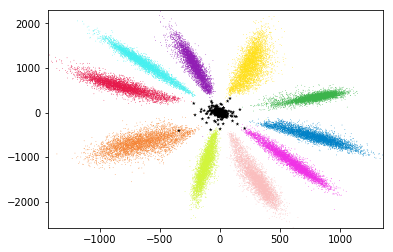

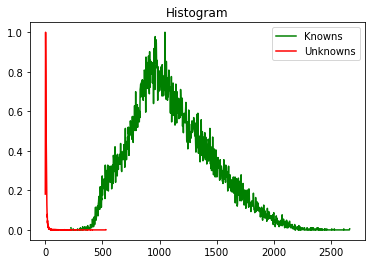

In [41]:
lettrs_intermediate_output=extract_features(Ring_Loss_Lenet_pp,letters.X_test)
plotter_2D(train_mnist_intermediate_output,mnist.labels_train,lettrs_intermediate_output)

[(None, 28, 28, 1), (None, 1), (None, 1)] 3


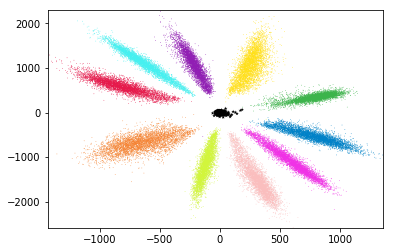

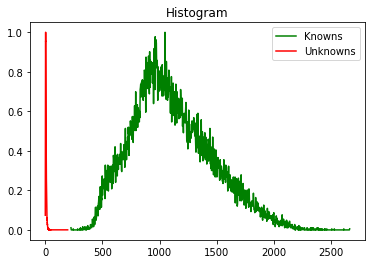

In [39]:
train_lettrs_intermediate_output=extract_features(Ring_Loss_Lenet_pp,letters.X_train)
plotter_2D(train_mnist_intermediate_output,mnist.labels_train,train_lettrs_intermediate_output)

[(None, 28, 28, 1), (None, 1), (None, 1)] 3
[(None, 28, 28, 1), (None, 1), (None, 1)] 3
[(None, 28, 28, 1), (None, 1), (None, 1)] 3
[(None, 28, 28, 1), (None, 1), (None, 1)] 3
[(None, 28, 28, 1), (None, 1), (None, 1)] 3


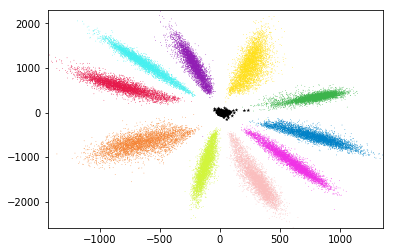

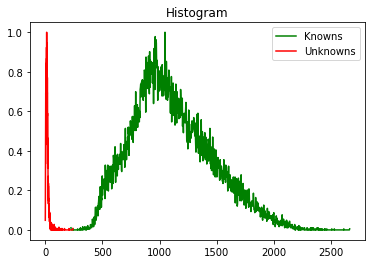

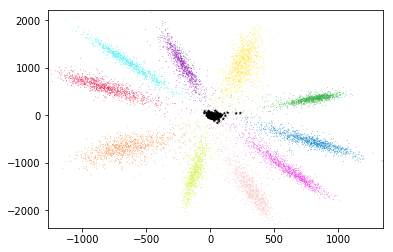

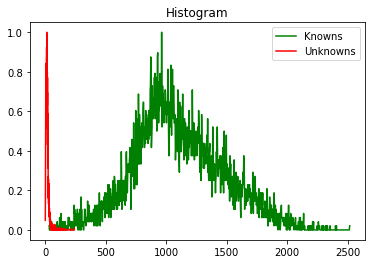

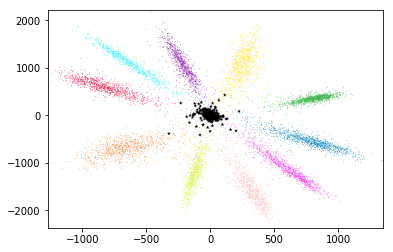

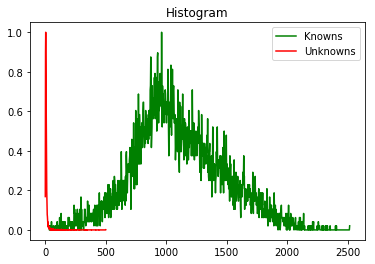

In [33]:
mnist_intermediate_output=extract_features(Ring_Loss_Lenet_pp,mnist.X_test)
cifar_intermediate_output=extract_features(Ring_Loss_Lenet_pp,cifar.images)
lettrs_intermediate_output=extract_features(Ring_Loss_Lenet_pp,letters.X_test)

train_mnist_intermediate_output=extract_features(Ring_Loss_Lenet_pp,mnist.X_train)
train_lettrs_intermediate_output=extract_features(Ring_Loss_Lenet_pp,letters.X_train)

#print mnist_intermediate_output.shape,mnist.labels_test.shape,cifar_intermediate_output.shape
#print mnist_intermediate_output,mnist.labels_test,cifar_intermediate_output
#plotter_2D(train_mnist_intermediate_output,mnist.labels_train,train_lettrs_intermediate_output)
plotter_2D(train_mnist_intermediate_output,mnist.labels_train,cifar_intermediate_output)
plotter_2D(mnist_intermediate_output,mnist.labels_test,cifar_intermediate_output)
plotter_2D(mnist_intermediate_output,mnist.labels_test,lettrs_intermediate_output)

In [19]:
res=Ring_Loss_Lenet_pp.test_on_batch(x=[mnist.X_test,np.ones((mnist.X_test.shape[0],1)),np.ones((mnist.X_test.shape[0],1))], y=[mnist.Y_test,np.ones((mnist.Y_test.shape[0],2))])

In [22]:
print Ring_Loss_Lenet_pp.metrics_names
print res

['loss', 'pred_loss', 'fc_loss', 'pred_acc', 'fc_acc']
[6.7674284, 3.3557415, 682.33734, 0.7791, 0.47559986]


In [31]:
Ring_Loss_Lenet_pp.history

In [43]:
print Ring_Loss_Lenet_pp.metrics_names

['loss', 'pred_loss', 'fc_loss', 'pred_acc', 'fc_acc']
